In [2]:
'''
Some of the code is referenced from 
https://towardsdatascience.com/hands-on-bayesian-statistics-with-python-pymc3-arviz-499db9a59501

'''


import pandas as pd
import numpy as np
import pymc3 as pm
from sklearn.model_selection import train_test_split
import arviz as az
import matplotlib.pyplot as plt

# Housing sales data 
Can be downloaded from https://www.kaggle.com/c/house-prices-advanced-regression-techniques

# Cleaning and preprocessing

In [4]:
data = pd.read_csv("train.csv")

In [25]:
data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [5]:
data = data.drop(['Alley','MiscFeature','Fence','PoolQC','FireplaceQu'],axis=1)

In [6]:
data = data.dropna()

In [7]:
data.shape

(1094, 76)

In [8]:
list_of_category_columns = list()
for x in data.columns:
    if data[x].dtype == 'O':
        list_of_category_columns.append(x)
list_of_category_columns.append('YrSold')

In [9]:
def categorical_to_numeric(data):
    data = pd.Categorical(data).codes
    return data

In [10]:
for col in list_of_category_columns:
    data[col] = categorical_to_numeric(data[col])
    

In [11]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,3,3,0,4,...,0,0,0,0,0,2,2,8,4,208500
1,2,20,3,80.0,9600,1,3,3,0,2,...,0,0,0,0,0,5,1,8,4,181500
2,3,60,3,68.0,11250,1,0,3,0,4,...,0,0,0,0,0,9,2,8,4,223500
3,4,70,3,60.0,9550,1,0,3,0,0,...,272,0,0,0,0,2,0,8,0,140000
4,5,60,3,84.0,14260,1,0,3,0,2,...,0,0,0,0,0,12,2,8,4,250000


In [17]:
data['SalePrice'] = data['SalePrice']/10000.0

# Finding the distribution of the output
Looks a lot like Gaussian distribution skewed towards the left

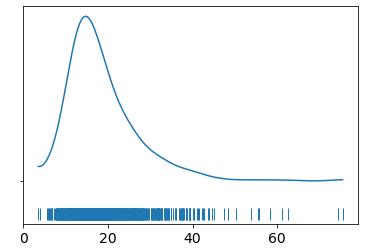

In [18]:
az.plot_kde(data['SalePrice'].values, rug=True)
plt.yticks([0], alpha=0);

In [19]:
data['SalePrice'].describe()

count    1094.000000
mean       18.703326
std         8.316533
min         3.531100
25%        13.250000
50%        16.575000
75%        22.100000
max        75.500000
Name: SalePrice, dtype: float64

# Defining a Bayesian model
Specifying the prior parameters (mean and standard deviation) and finding the posterior distribution

In [20]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=0, upper=100)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data['SalePrice'].values)
    trace_g = pm.sample(1000, tune=1000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


# Plotting the posterior distribution and comparing with the distribution of the observed data

/home/sudhir/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


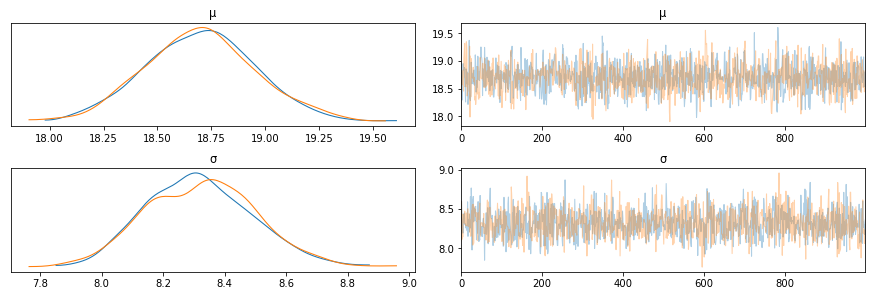

In [21]:
az.plot_trace(trace_g);

# Sampling from the posterior distribution and plotting to check the properties of the distribution

In [27]:
ppc = pm.sample_posterior_predictive(trace_g, samples=1000, model=model_g)
np.asarray(ppc['y']).shape

(1000, 1094)

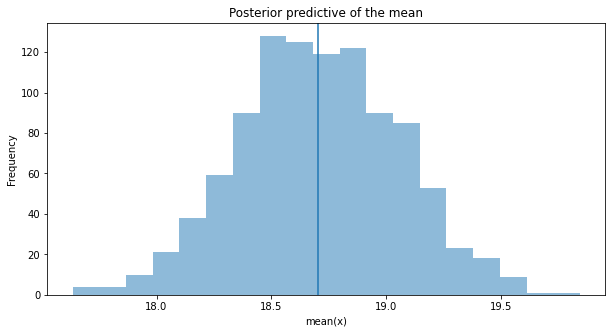

In [28]:
_, ax = plt.subplots(figsize=(10, 5))
ax.hist([y.mean() for y in ppc['y']], bins=19, alpha=0.5)
ax.axvline(data.SalePrice.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');